# Transformers for Image Recognition at Scale

In [ ]:
# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
# https://arxiv.org/abs/2010.11929

## Import Libraries

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from pathlib import Path
import requests
import os

from zipfile import ZipFile

In [ ]:
import torch
torch.__version__

'2.3.0+cu121'

In [ ]:
import torchvision
torchvision.__version__

'0.18.0+cu121'

In [ ]:
import torch.nn as nn

In [ ]:
!pip install -q torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Download Data

In [ ]:
path_data = Path('data/')
path_img = path_data / 'pizza_steak_sushi'

path_img

PosixPath('data/pizza_steak_sushi')

In [ ]:
if not path_img.is_dir():
    print(f'[INFO] creating the "{path_img}" ...')
    path_img.mkdir(parents= True, exist_ok= True)

In [ ]:
url_images = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'

target_file = Path(url_images).name
target_file

'pizza_steak_sushi.zip'

In [ ]:
with open(path_data / target_file, 'wb') as f:
    req = requests.get(url_images)
    print(f'[INFO] Downloading data from \n{url_images}\nto {target_file}')
    f.write(req.content)

[INFO] Downloading data from 
https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
to pizza_steak_sushi.zip


In [ ]:
with ZipFile(path_data / target_file, 'r') as zip_ref:
    print(f'[INFO] Unzipping {target_file} to {path_img}')
    zip_ref.extractall(path_img)

[INFO] Unzipping pizza_steak_sushi.zip to data/pizza_steak_sushi


In [ ]:
dir_trn = path_img / 'train'
dir_tst = path_img / 'test'

In [ ]:
dir_trn

PosixPath('data/pizza_steak_sushi/train')

## Create DataLoaders

In [ ]:
from torchvision import datasets
import torchvision.transforms as T

from torch.utils.data import DataLoader

In [ ]:
NUM_WORKERS = os.cpu_count()
NUM_WORKERS

2

In [ ]:
BATCH_SIZE = 16

In [ ]:
IMG_SIZE = 224 # table 3: "training resolution is 224"

In [ ]:
transforms_manual = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

transforms_manual

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
data_trn = datasets.ImageFolder(dir_trn, transform= transforms_manual)
data_tst = datasets.ImageFolder(dir_tst, transform= transforms_manual)

In [ ]:
class_names = data_trn.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
len(data_trn), len(data_tst)

(225, 75)

In [ ]:
dataloader_params = {'batch_size': BATCH_SIZE, 'num_workers': NUM_WORKERS}

dataloader_trn = DataLoader(data_trn, shuffle= True, pin_memory= True, **dataloader_params)
dataloader_tst = DataLoader(data_tst, shuffle= False, pin_memory= True, **dataloader_params)

In [ ]:
len(dataloader_trn), len(dataloader_tst) # 15 * 16 ~ 225; 16 * 5 ~ 75

(15, 5)

In [ ]:
images, labels = next(iter(dataloader_trn))

idx = random.randint(0, BATCH_SIZE)
img_sample, label_sample = images[idx], labels[idx]

img_sample.shape, label_sample

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

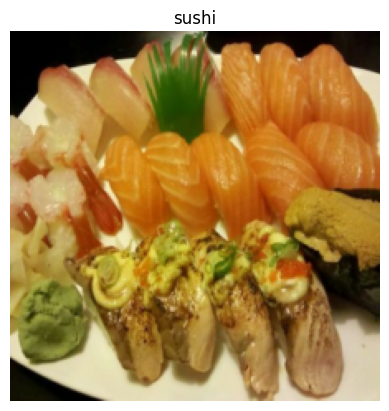

In [ ]:
img = img_sample.permute(1, 2, 0)
plt.imshow(img)
plt.title(class_names[label_sample])
plt.axis(False)

## Replicating ViT: Overview

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

In [ ]:
# h, w, c = 224, 224, 3
# p = 16
# hence: N (number of patches) = hxw/pxp
#

# =>
# embedding input shape: h x w x c
# embedding output shape: N flattened vector of size: p * p * c


In [ ]:
img.shape

torch.Size([224, 224, 3])

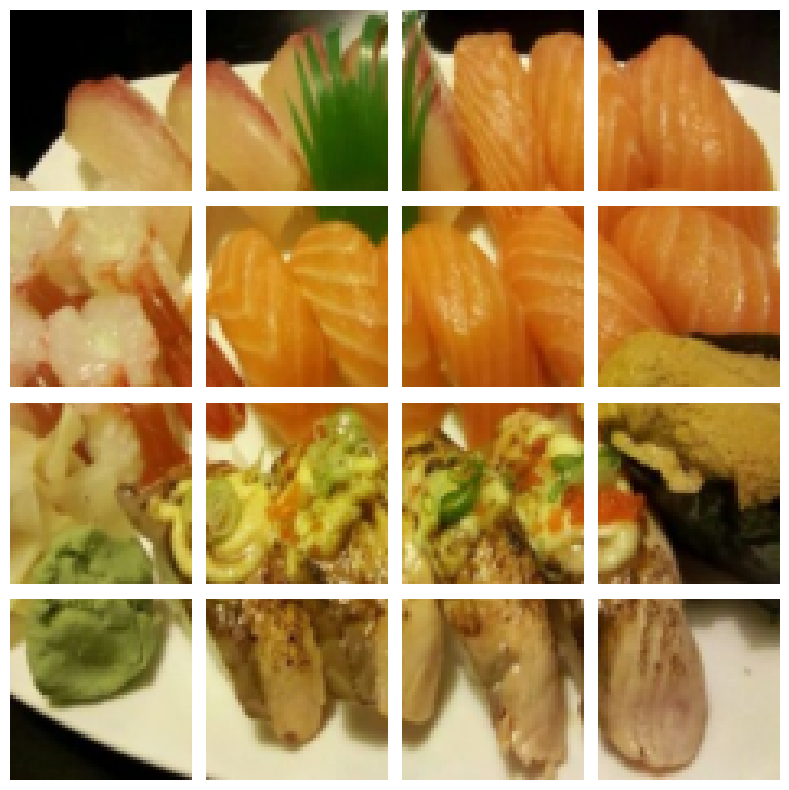

In [ ]:
h, w, c = 224, 224, 3
PATCH_SIZE = 56  # only for the plotting; otherwise the PATCH_SIZE is 16
rows, cols = h // PATCH_SIZE, w // PATCH_SIZE

fig, axes = plt.subplots(rows, cols, figsize= (8, 8))

# Extract and plot patches
for i in range(rows):
    for j in range(cols):
        patch = img[i * PATCH_SIZE:(i + 1) * PATCH_SIZE, j * PATCH_SIZE:(j + 1) * PATCH_SIZE]
        axes[i, j].imshow(patch)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


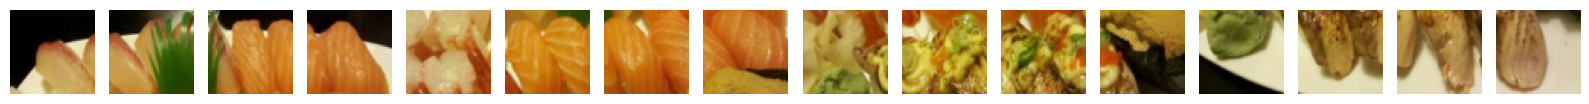

In [ ]:
fig, axes = plt.subplots(1, rows * cols, figsize= (16, 64*3))

# Extract and plot patches
for i in range(rows):
    for j in range(cols):
        patch = img[i * PATCH_SIZE:(i + 1) * PATCH_SIZE, j * PATCH_SIZE:(j + 1) * PATCH_SIZE]
        axes[i*rows+j].imshow(patch)
        axes[i*rows+j].axis('off')

plt.tight_layout()
plt.show()


### create image patches & turn them into learnables

In [ ]:
PATCH_SIZE = 56
D = PATCH_SIZE ** 2 * c # embedding size

In [ ]:
conv_2d = nn.Conv2d(
    in_channels= c,
    out_channels= D,
    kernel_size= PATCH_SIZE,
    stride= PATCH_SIZE,
    padding= 0
)

conv_2d

Conv2d(3, 9408, kernel_size=(56, 56), stride=(56, 56))

In [ ]:
img.shape, img_sample.shape

(torch.Size([224, 224, 3]), torch.Size([3, 224, 224]))

In [ ]:
img.permute(2, 0, 1).unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [ ]:
out_conv2d = conv_2d(img.permute(2, 0, 1).unsqueeze(0))
# now we have 4 * 4 `patch/sub_images` of size 768 (they're flattened)
out_conv2d.shape

torch.Size([1, 9408, 4, 4])

In [ ]:
out_conv2d.requires_grad # fyi

True

In [ ]:
out_conv2d.squeeze().shape

torch.Size([9408, 4, 4])

In [ ]:
out_conv2d.squeeze()[:, 0, 0].shape

torch.Size([9408])

In [ ]:
patch = out_conv2d.squeeze()[:, 0, 0].view(c, PATCH_SIZE, PATCH_SIZE)
patch.shape

torch.Size([3, 56, 56])

In [ ]:
pmin, pmax = patch.max(), patch.min()
pmin, pmax

(tensor(0.9025, grad_fn=<MaxBackward1>),
 tensor(-0.9880, grad_fn=<MinBackward1>))

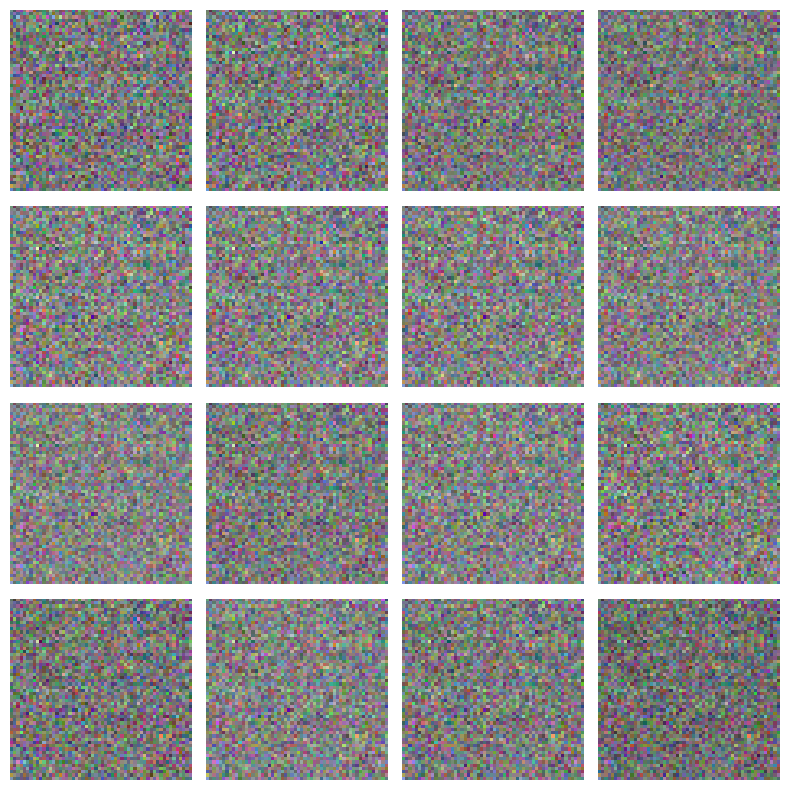

In [ ]:
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize= (8, 8))

# Extract and plot patches
for i in range(rows):
    for j in range(cols):
        patch = out_conv2d.squeeze()[:, i, j].view(c, PATCH_SIZE, PATCH_SIZE)
        patch = patch.permute(1, 2, 0).detach().numpy()
        # map the values to [0, 1]
        pmin, pmax = patch.max(), patch.min()
        patch = (patch - pmin) / (pmax - pmin)
        axes[i, j].imshow(patch)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
out_conv2d.shape

torch.Size([1, 9408, 4, 4])

In [ ]:
flatten_layer = nn.Flatten(start_dim= 2, end_dim= 3)

# now we have flattened each patch to a learnable/embeddings of size D
# i.e. shape is: <batch_size, number_of_patches, embedding_size>
flatten_layer(out_conv2d).permute(0, 2, 1).shape

torch.Size([1, 16, 9408])

In [ ]:
# putting it all together

class PatchEmbed(nn.Module):
    def __init__(self, img_shape, patch_size):
        """
        img_shape: <batch_size, c, h, w>
        """
        super().__init__()
        self.c, self.h, self.w = img_shape[1:]
        self.patch_size = patch_size
        assert self.h % self.patch_size == 0, 'Image size should be divisible by patch_size.'
        # embedding size is the flattened size of each patch:
        # self.c (color channels) & square of self.patch size
        self.embedding_size = self.patch_size ** 2 * self.c

        self.patchify = nn.Conv2d(
            in_channels= self.c,
            out_channels= self.embedding_size,
            kernel_size= self.patch_size,
            stride= self.patch_size,
            padding= 0
        )

        self.flatten = nn.Flatten(start_dim= 2, end_dim= 3)

    def forward(self, x):
        print('x => ', x.shape)
        c, h, w = x.shape[1:]
        assert h % self.patch_size == 0, 'Bad shape!'
        x = self.patchify(x)
        print('x (patched) => ', x.shape)
        x = self.flatten(x)
        print('x (flattened) => ', x.shape)
        return x.permute(0, 2, 1)

In [ ]:
foo = img_sample.unsqueeze(0)
patchify = PatchEmbed(foo.shape, patch_size= 16)

img_pe = patchify(foo)
img_pe.shape

x =>  torch.Size([1, 3, 224, 224])
x (patched) =>  torch.Size([1, 768, 14, 14])
x (flattened) =>  torch.Size([1, 768, 196])


torch.Size([1, 196, 768])

In [ ]:
bar = torch.randn(1, 3, 225, 225)

try:
    z = patchify(bar) # AssertionError: Bad shape!
    print(z.shape)
except AssertionError as e:
    print(e)


x =>  torch.Size([1, 3, 225, 225])
Bad shape!


### class token

![](https://drive.usercontent.google.com/u/0/uc?id=1g9fHtpWIg69VMdJ14jHvoFZes_lq2uAe)

In [ ]:
# the shape of the output of patched embedding layer:
img_pe.shape

torch.Size([1, 196, 768])

In [ ]:
batch_size, _, embed_size = img_pe.shape
batch_size, embed_size

(1, 768)

In [ ]:
# Every batch is consisted of N patches: N = (img_size ** 2 / patch_size ** 2)
# each patch is of dimension: D = c x patch_size x patch_size
# hence, our embeddings are <batch_size, N, D>
# now we want to add a single class learnable to each of those N embeddings
# => the final shape will be <batch_size, 1+ N, D>
# For demonstrations purpose, we used `torch.ones()` so that it's clear
# otherwise we'll initialize random weights. `requires_grad = True` makes sure it's learnable.
class_token = nn.Parameter(torch.ones(batch_size, 1, embed_size), requires_grad= True)

class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Prepend the `class_token` to the `patch_embeddings` (img_pe)
z = torch.cat((class_token, img_pe), dim= 1)
z.shape

torch.Size([1, 197, 768])

In [ ]:
class_token.shape, img_pe.shape

(torch.Size([1, 1, 768]), torch.Size([1, 196, 768]))

In [ ]:
# as you see, now the shape is `<batch_size, 1+ N, D>`
# and the 1 in `1 + N` is the tensor we've added (vector of ones)
# again, we'll initialize the `class_token` randommly.
z

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0335,  0.0167,  0.0333,  ...,  0.0355, -0.0183, -0.0079],
         [ 0.0340,  0.0181,  0.0332,  ...,  0.0347, -0.0170, -0.0077],
         ...,
         [ 0.0647,  0.6690,  0.5510,  ...,  0.0589,  0.3339,  0.2554],
         [ 0.1389,  0.9859,  0.6168,  ...,  0.1439,  0.3230,  0.2270],
         [ 0.0872,  1.0568,  0.7125,  ...,  0.0848,  0.4309,  0.4107]]],
       grad_fn=<CatBackward0>)

### position embedding

In [ ]:
z

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0335,  0.0167,  0.0333,  ...,  0.0355, -0.0183, -0.0079],
         [ 0.0340,  0.0181,  0.0332,  ...,  0.0347, -0.0170, -0.0077],
         ...,
         [ 0.0647,  0.6690,  0.5510,  ...,  0.0589,  0.3339,  0.2554],
         [ 0.1389,  0.9859,  0.6168,  ...,  0.1439,  0.3230,  0.2270],
         [ 0.0872,  1.0568,  0.7125,  ...,  0.0848,  0.4309,  0.4107]]],
       grad_fn=<CatBackward0>)

In [ ]:
z.shape

torch.Size([1, 197, 768])

In [ ]:
pos_embed = nn.Parameter(torch.randn_like(z), requires_grad= True)
pos_embed.shape

torch.Size([1, 197, 768])

In [ ]:
# update z
z += pos_embed
z.shape # should stay the same

torch.Size([1, 197, 768])

In [ ]:
pos_embed

Parameter containing:
tensor([[[-0.1173, -1.4417,  0.3540,  ..., -0.4277,  0.5525, -0.4584],
         [ 0.4876,  0.6548,  1.5658,  ...,  0.2197, -1.5732,  0.5022],
         [-1.6666, -1.4569, -0.3035,  ...,  0.0277,  1.9651, -1.5326],
         ...,
         [ 0.7369,  0.8220,  0.5417,  ...,  0.3202, -1.4077,  0.5349],
         [-0.0474,  1.5445,  0.3422,  ...,  0.3052,  0.3737, -2.3907],
         [ 0.8357,  0.3076, -1.5042,  ..., -0.4878, -0.5123, -0.2532]]],
       requires_grad=True)

In [ ]:
z

tensor([[[ 0.8827, -0.4417,  1.3540,  ...,  0.5723,  1.5525,  0.5416],
         [ 0.5210,  0.6715,  1.5991,  ...,  0.2552, -1.5915,  0.4943],
         [-1.6326, -1.4388, -0.2703,  ...,  0.0624,  1.9481, -1.5403],
         ...,
         [ 0.8016,  1.4909,  1.0927,  ...,  0.3791, -1.0738,  0.7904],
         [ 0.0915,  2.5305,  0.9590,  ...,  0.4491,  0.6967, -2.1637],
         [ 0.9228,  1.3645, -0.7917,  ..., -0.4031, -0.0814,  0.1574]]],
       grad_fn=<AddBackward0>)